# [GD-04] 이미지 어디까지 우려볼까?
augmentation 기법을 적용해 ResNet-50을 학습시킨다.

## Augmentation 적용 (1) 데이터 불러오기
Augmentation도 입력 이미지의 데이터를 변경해주는 과정이므로 일반적인 이미지 데이터 전처리 방법과 활용방법이 동일하다.

In [ ]:
# 필요한 라이브러리 불러오기
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete9R5HHS/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete9R5HHS/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


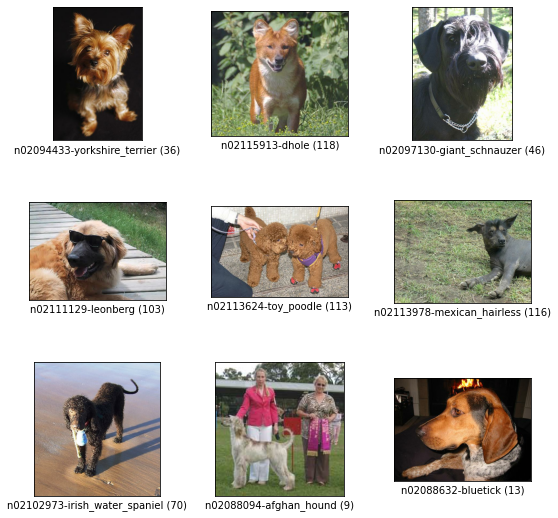

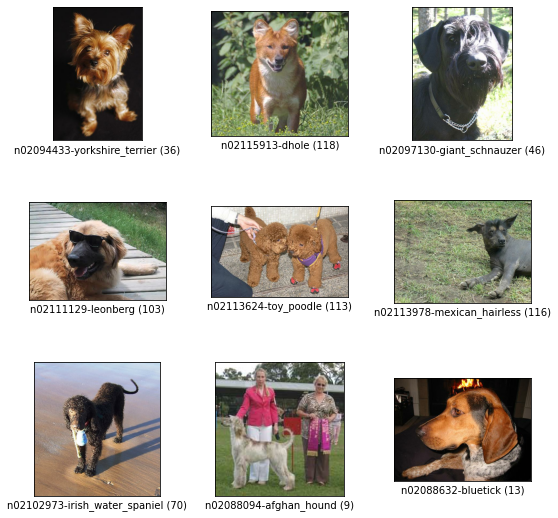

In [ ]:
tfds.show_examples(ds_train, ds_info)

## Augmentation 적용 (2) Augmentation 적용하기
많은 augmentation 기법들이 있지만 그 중에서 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해본다. 먼저 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같다.
* random_brightness()
* random_contrast()
* random_crop()
* random_flip_left_right()
* random_flip_up_down()
* random_hue()
* random_jpeg_quality()
* random_saturation()

In [ ]:
# 기본적인 전처리 함수
def normalize_and_resize(image, label):
  image = tf.image.resize(image, [224, 224])
  return tf.cast(image, tf.float32) / 255., label

이러면 이미지 변환의 결과로 리턴 받은 이미지를 그 다음 전처리 함수의 입력으로 연거푸 재사용할 수 있는 구조가 되어 편리하다. 이 함수는 입력받은 이미지를 0-1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize한다. 

In [ ]:
def augment(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

normalize, resize, augmentation과 shuffle같은 일반적인 전처리 과정 중 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 한다.

테스트 데이터셋에는 앙상블(ensemble) 방법 중 하나인 TTA(Test Time Augmentation)이라는 방법이 있다. 이 방법은 테스트 데이터셋에 augmentation을 적용한다.
* TTA
  * 증강된 이미지를 여러 번 보여준 다음 각각의 단계에 대해서 prediction을 평균하고 이 결과를 최종값으로 사용하는 것.

In [ ]:
# 데이터셋을 가공하는 메인 함수
# 이후에 수행할 비교실험을 위해 with_aug 매개 변수를 통해 augmentation 적용 여부를 결정할 수 있게 한다.

# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [ ]:
# make random augment function
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

## Augmentation 적용 (3) 비교실험 하기
augmentation을 적용한 데이터를 학습시킨 모델과 그렇지 않은 데이터를 학습시킨 모델의 성능을 비교한다. 

아래 코드는 tensorflow keras의 ResNet50 중 imagenet으로 훈련된 모델을 불러온다. include_top은 마지막 fully connected layer를 포함할지 여부이다. 해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있다. 이렇게 하는 이유는 이미지넷과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야하는 fully connected layer의 구조또한 다르기 때문이다.

In [ ]:
num_classes = ds_info.features['label'].num_classes
resnet50 = keras.models.Sequential([
                                    keras.applications.resnet.ResNet50(
                                        include_top = False,
                                        weights = 'imagenet',
                                        input_shape = (224, 224, 3),
                                        pooling = 'avg',

                                    ),
                                    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# augmentation을 적용한 데이터셋으로 학습시킬 resnet
aug_resnet50 = keras.models.Sequential([
                                        keras.applications.resnet.ResNet50(
                                            include_top = 'False',
                                            weights = 'imagenet',
                                            input_shape = (224, 224, 3),
                                            pooling = 'avg',
                                        ),
                                        keras.layers.Dense(num_classes, activation='softmax')
])

102981632/102967424 [==============================] - 0s 0us/step


In [ ]:
# 텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug를 False로 주어 적용되지 않게하고,
# 다른 하나는 True로 주어 augmentation이 적용되도록 한다.

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split = ['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
EPOCH = 3

resnet50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 102s 115ms/step - loss: 2.1972 - accuracy: 0.4450 - val_loss: 3.2079 - val_accuracy: 0.2409
Epoch 2/3
750/750 [==============================] - 86s 114ms/step - loss: 0.7585 - accuracy: 0.7891 - val_loss: 1.2416 - val_accuracy: 0.6399
Epoch 3/3
750/750 [==============================] - 86s 114ms/step - loss: 0.2485 - accuracy: 0.9459 - val_loss: 1.0001 - val_accuracy: 0.7094


In [ ]:
aug_resnet50.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy'],
)
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = EPOCH,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing=True
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 94s 116ms/step - loss: 4.7839 - accuracy: 0.0346 - val_loss: 4.7854 - val_accuracy: 0.0152
Epoch 2/3
750/750 [==============================] - 86s 115ms/step - loss: 4.7742 - accuracy: 0.1007 - val_loss: 4.7634 - val_accuracy: 0.1775
Epoch 3/3
750/750 [==============================] - 86s 115ms/step - loss: 4.7598 - accuracy: 0.1819 - val_loss: 4.7450 - val_accuracy: 0.2425


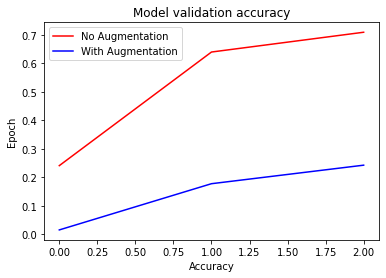

In [ ]:
# 훈련과정 시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

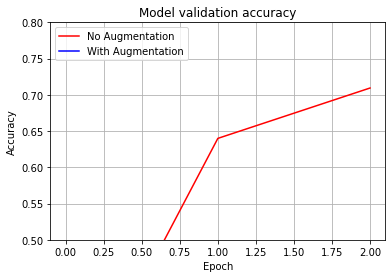

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## 심화 기법 (1) Cutmix Augmentation
CutMix는 이미지 데이터를 자르고 섞는다고 생각할 수 있다.

Mixup은 특정 비율로 픽셀별 값을 섞는 방식이고, Cutout은 이미지를 잘라내는 방식이다. CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법이다. 차에 비유하면 블렌딩 같은 방법임.

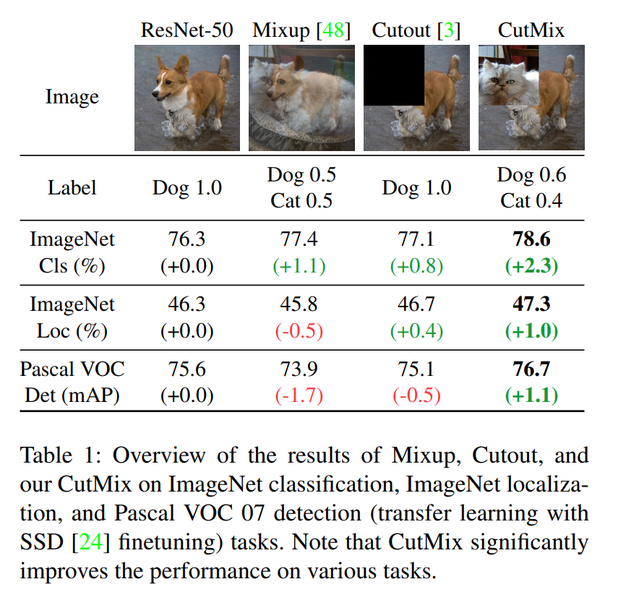

* 이미지 섞기 
  * 가장 먼저 두 개의 이미지를 섞어주는 것부터 생각해보자. 배치 내의 이미지를 두 개 골라서 섞어준다. 이 때 이미지에서 잘라서 섞어주는 영역을 **바운딩 박스(bounding box)라고 부른다.**

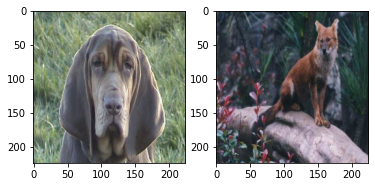

In [ ]:
# 바운딩 박스의 위치를 랜덤하게 뽑고 이를 잘라내서 두 개의 이미지를 섞어주는 함수를 만듦
# 이미지를 텐서로 만들어 텐서플로우 연산을 사용
# 이미지는 tfds에서 한 장을 뽑아서 사용

import matplotlib.pyplot as plt

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
  if i == 0:
    image_a = image[0]
    image_b = image[1]
    label_a = label[0]
    label_b = label[1]
    break

plt.subplot(1, 2, 1)
plt.imshow(image_a)

plt.subplot(1, 2, 2)
plt.imshow(image_b)

plt.show()

위 두 이미지 중 첫 번째 이미지 a를 바탕 이미지로 하고, 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 구현해보자.

이번 노드에서는 이미지 a, b가 모두 (224, 224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만, Cutmix 공식 repo에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에, 임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현해본다. 

In [ ]:
def get_clip_box(image_a, image_b):
  # image.shape = (height, width, channel)
  image_size_x = image_a.shape[1]
  image_size_y = image_a.shape[0]

  # get center of box
  x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
  y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

  # get width, height of box
  width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
  height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

  # clip box in image and get minmax bbox
  x_min = tf.math.maximum(0, x-width//2)
  y_min = tf.math.maximum(0, y-height//2)
  x_max = tf.math.minimum(image_size_x, x+width//2)
  y_max = tf.math.minimum(image_size_y, y+width//2)

  return x_min, y_min, x_max, y_max


x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)


x :  tf.Tensor(104, shape=(), dtype=int32) tf.Tensor(144, shape=(), dtype=int32)
y :  tf.Tensor(98, shape=(), dtype=int32) tf.Tensor(189, shape=(), dtype=int32)


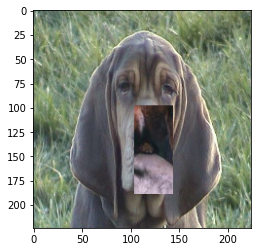

In [ ]:
# 바탕 이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

* 라벨 섞기
  * 이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 한다. 
  * CutMix에서는 면적에 비례해서 라벨을 섞어준다. 섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해준다. 예를 들어, A 클래스를 가진 원래 이미지 image_a와 B 클래스를 가진 이미지 image_b를 섞을 때 image_a를 0.4 만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해준다.
  * 이 때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용한다.

In [ ]:
# 위에서 섞인 이미지 두 가지에 대해 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.92745537, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [ ]:
# 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용해 배치 단위의 cutmix() 함수 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


## 심화 기법 (2) Mixup Augmentation
Mixup은 앞에서 본 CutMix보다 간단하게 이미지와 라벨을 섞어준다. 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식으로 CutMix보다 구현이 간단하다고 볼 수 있다. 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 된다.

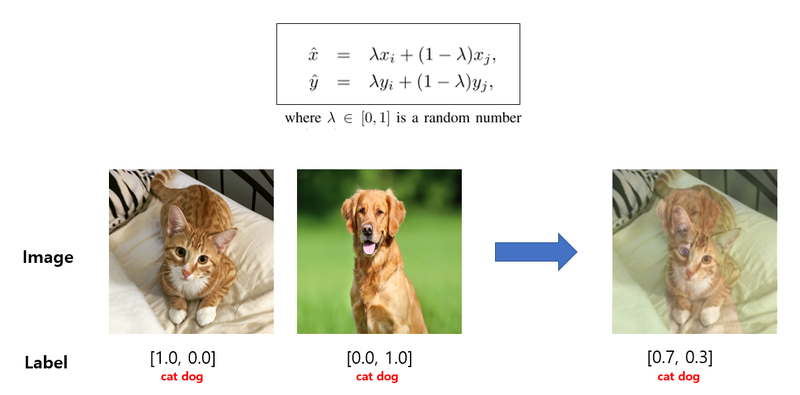

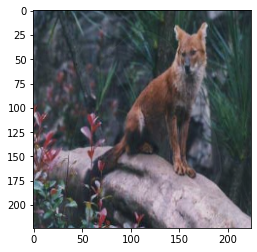

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.09332919 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [ ]:
# 배치 단위의 mixup() 함수 
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


## 프로젝트: CutMix 또는 Mixup 비교실험 하기
* 루브릭

|평가문항|상세기준|
|-|-|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentation 미적용시 대비 5% 이상의 성능향상을 확인함.|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교 분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

In [ ]:
# 라이브러리 
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# 데이터셋 로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteLO6PET/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteLO6PET/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


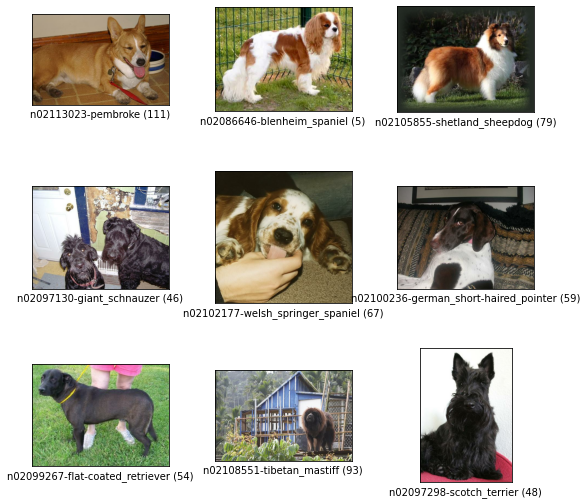

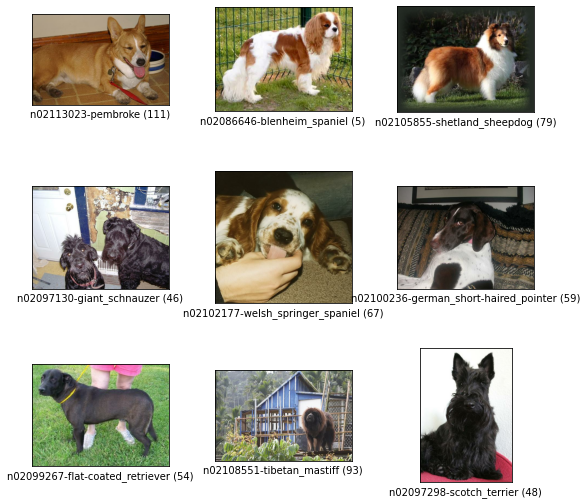

In [ ]:
tfds.show_examples(ds_train, ds_info)

### 기본 augmentation

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

### Cutmix Augmentation

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [ ]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


### Mixup Augmentation

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    onehot_imgs = []
    onehot_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        if len(label_a.shape)==0:
            label_a = tf.one_hot(label_a, num_classes)
        
        onehot_imgs.append(image_a)
        onehot_labels.append(label_a)

    onehot_imgs = tf.reshape(tf.stack(onehot_imgs),(batch_size, img_size, img_size, 3))
    onehot_labels = tf.reshape(tf.stack(onehot_labels),(batch_size, num_classes))
    return onehot_imgs, onehot_labels


### Augmentation을 적용한 데이터셋

In [ ]:
'''
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label
'''

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


### 모델 만들기

In [ ]:
num_classes = ds_info.features["label"].num_classes

In [ ]:
# Cutmix 모델
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
print(resnet50_cutmix.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 120)               245880    
                                                                 
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________
None


In [ ]:
# Mixup 모델
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
# augmentation 없는 순수한 모델
resnet50_plain = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
# 기본 augmentation만 적용한 모델
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train,  with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train,  with_mixup=True)
ds_train_plain = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### 모델 훈련하기

In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, # with_aug, with_cutmix = True
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 108s 123ms/step - loss: 3.8054 - accuracy: 0.2221 - val_loss: 3.7462 - val_accuracy: 0.1625
Epoch 2/20
750/750 [==============================] - 91s 122ms/step - loss: 2.9401 - accuracy: 0.4313 - val_loss: 1.3744 - val_accuracy: 0.6163
Epoch 3/20
750/750 [==============================] - 91s 122ms/step - loss: 2.6190 - accuracy: 0.5392 - val_loss: 1.2199 - val_accuracy: 0.6523
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 2.4198 - accuracy: 0.6041 - val_loss: 1.1657 - val_accuracy: 0.6785
Epoch 5/20
750/750 [==============================] - 93s 124ms/step - loss: 2.2396 - accuracy: 0.6641 - val_loss: 1.4439 - val_accuracy: 0.6198
Epoch 6/20
750/750 [==============================] - 93s 124ms/step - loss: 2.1509 - accuracy: 0.6886 - val_loss: 1.2172 - val_accuracy: 0.6743
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 2.0408 - accuracy: 0.7253 - val_loss: 1.3174 - val_accuracy: 0.

In [ ]:
# mixup
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, # with_aug, with_mixup = True
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 102s 126ms/step - loss: 3.6970 - accuracy: 0.2411 - val_loss: 3.7898 - val_accuracy: 0.1391
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 2.8665 - accuracy: 0.4838 - val_loss: 1.5105 - val_accuracy: 0.5798
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 2.5694 - accuracy: 0.5850 - val_loss: 1.3110 - val_accuracy: 0.6361
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 2.3798 - accuracy: 0.6590 - val_loss: 1.3105 - val_accuracy: 0.6386
Epoch 5/20
750/750 [==============================] - 91s 121ms/step - loss: 2.2633 - accuracy: 0.7061 - val_loss: 1.3666 - val_accuracy: 0.6299
Epoch 6/20
750/750 [==============================] - 91s 121ms/step - loss: 2.1463 - accuracy: 0.7542 - val_loss: 1.2706 - val_accuracy: 0.6581
Epoch 7/20
750/750 [==============================] - 91s 121ms/step - loss: 2.0542 - accuracy: 0.7824 - val_loss: 1.2443 - val_accuracy: 0.

In [ ]:
resnet50_plain.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_plain = resnet50_plain.fit(
    ds_train_plain, # plain model
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing = True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 99s 122ms/step - loss: 2.2003 - accuracy: 0.4468 - val_loss: 3.1177 - val_accuracy: 0.2522
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 0.6904 - accuracy: 0.8102 - val_loss: 1.0033 - val_accuracy: 0.6983
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1852 - accuracy: 0.9657 - val_loss: 0.9244 - val_accuracy: 0.7299
Epoch 4/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0464 - accuracy: 0.9973 - val_loss: 0.9054 - val_accuracy: 0.7355
Epoch 5/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0198 - accuracy: 0.9998 - val_loss: 0.9081 - val_accuracy: 0.7406
Epoch 6/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0151 - accuracy: 0.9998 - val_loss: 0.9403 - val_accuracy: 0.7359
Epoch 7/20
750/750 [==============================] - 94s 126ms/step - loss: 0.0422 - accuracy: 0.9952 - val_loss: 0.9698 - val_accuracy: 0.7

In [ ]:
resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # with_aug
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 101s 126ms/step - loss: 2.2659 - accuracy: 0.4287 - val_loss: 2.9082 - val_accuracy: 0.2878
Epoch 2/20
750/750 [==============================] - 91s 121ms/step - loss: 0.9096 - accuracy: 0.7428 - val_loss: 1.3556 - val_accuracy: 0.6174
Epoch 3/20
750/750 [==============================] - 94s 125ms/step - loss: 0.4809 - accuracy: 0.8707 - val_loss: 1.1305 - val_accuracy: 0.6688
Epoch 4/20
750/750 [==============================] - 91s 121ms/step - loss: 0.2407 - accuracy: 0.9446 - val_loss: 0.9916 - val_accuracy: 0.7136
Epoch 5/20
750/750 [==============================] - 92s 123ms/step - loss: 0.1278 - accuracy: 0.9778 - val_loss: 0.9471 - val_accuracy: 0.7306
Epoch 6/20
750/750 [==============================] - 96s 127ms/step - loss: 0.0713 - accuracy: 0.9909 - val_loss: 0.9809 - val_accuracy: 0.7246
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0445 - accuracy: 0.9948 - val_loss: 0.9326 - val_accuracy: 0.

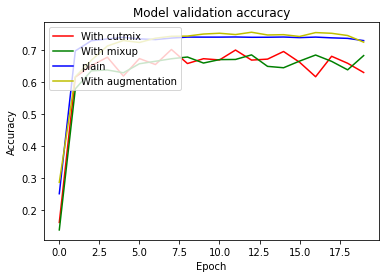

In [ ]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_plain.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With cutmix', 'With mixup', 'plain', 'With augmentation'], loc='upper left')
plt.show()

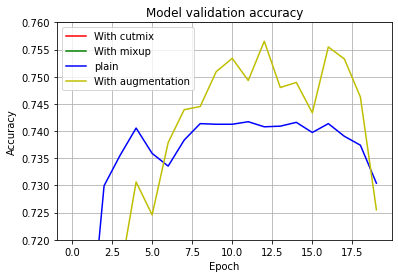

In [ ]:
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_plain.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['With cutmix', 'With mixup', 'plain', 'With augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)
plt.show()

In [ ]:
import pandas as pd

comparison = pd.DataFrame({'With Cutmix':history_resnet50_cutmix.history['val_accuracy'],
                           'With Mixup':history_resnet50_mixup.history['val_accuracy'],
                           'plain':history_resnet50_plain.history['val_accuracy'],
                           'With Augmentation':history_resnet50_aug.history['val_accuracy']
                           })
comparison

,With Cutmix,With Mixup,plain,With Augmentation
0,0.162547,0.139109,0.252215,0.287780
1,0.616255,0.579757,0.698344,0.617421
2,0.652285,0.636077,0.729944,0.668843
3,0.678521,0.638643,0.735541,0.713619
4,0.619753,0.629897,0.740555,0.730644
5,0.674324,0.658116,0.735891,0.724580
6,0.655667,0.665812,0.733559,0.737873
7,0.702659,0.673741,0.738340,0.743937
8,0.658815,0.679105,0.741371,0.744520
9,0.673857,0.660331,0.741255,0.750933


In [ ]:
comparison.describe()

,With Cutmix,With Mixup,plain,With Augmentation
count,20.000000,20.000000,20.000000,20.000000
mean,0.637815,0.631238,0.712063,0.710010
std,0.114767,0.118475,0.108665,0.104917
min,0.162547,0.139109,0.252215,0.287780
25%,0.646922,0.638993,0.735045,0.725280
50%,0.666161,0.662955,0.739389,0.744228
75%,0.675373,0.672079,0.741255,0.749708
max,0.702659,0.685868,0.741721,0.756530


* 회고
  * cutmix, mixup 모델의 성능이 기본모델과 augmentation만 적용한 모델보다 낮게 나왔다. 우선 cutmix와 mixup에 augmentation을 적용하지 않아서라고 추정해볼 수 있을 것 같다. with_aug를 True로 주고 두 모델을 학습했을 때 shapes (none, 1) and (none, 120) are incompatible 오류가 발생해 결국 False로 두고 학습을 진행했는데 아마 augmentation을 적용했다면 성능이 더 향상될 것 같다. 
  * image_a is not define 오류가 발생. 노드에서는 image_a를 선언하고 하나씩의 이미지를 받아와 처리해서 오류 없이 넘어갔지만 프로젝트에서는 image_a를 따로 선언해주지 않아서 오류가 생겼었다. 따로 함수에 인자로 넘겨주어 해결하였다. 
  * onehot 함수 없이 했을 때 오류가 생겼음. 이건 이유를 잘 모르겠다. 변환 과정 중에 생긴 오류라고 의심은 된다. 
  * 오류 해결에 도움을 주셨던 분들 덕에 마무리 할 수 있었던 노드였다...